In [29]:
# Clip dataset
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import os
import json
import torchvision
import datetime
from subprocess import Popen, PIPE
import re

class SoccerNetDataset_sound(Dataset):
    """Soccernet Dataset"""
    
    def __init__(self,npy_file,
                 root_dir,nframes=1,
                 stride_frames=1,
                 frame_center='center',
                 transform=None,
                 background=False,
                 tshift={'active':False,
                         'mu':0,'sigma':(0.4/3), 
                         'interval':[-0.45,0.45],
                         'mode': 'uniform'}):
        self.npy_file = np.load(npy_file)
        self.samples = list() # maybe change structure later depending on efficiency        
        self.tshift = tshift
        self.root_dir = root_dir
        self.transform = transform
        self.frame_center = frame_center
        self.nframes = nframes
        self.stride_frames = stride_frames
        self.background = background
        print(self.background)
        # For each path in npy_file, get all annotations
        outer_anchors_1 = []
        outer_anchors_2 = []

        for e in self.npy_file:
            path, annotations = self.get_annotations(e)

            duration1 = self.getVideoLength(self.root_dir + e + "/1_conv.avi")
            duration2 = self.getVideoLength(self.root_dir + e + "/2_conv.avi")
            #print(f"duration1 : {duration1}, duration2: {duration2}")
            for annotation in annotations:
                # Check that annotations hold correct labels
                        if ("card" in annotation["label"]) or ("subs" in annotation["label"]) or ("soccer" in annotation["label"]):
                            annotation["duration1"] = duration1
                            annotation["duration2"] = duration2
                            self.samples.append([path,annotation])

            if self.background: 
                # create background data such that closest anchor is 60s away, meeting the definition for background in classification task
                anchors_1 = []
                anchors_2 = []

                for annotation in annotations:
                    if ("card" in annotation["label"]) or ("subs" in annotation["label"]) or ("soccer" in annotation["label"]):
                        time_half = int(annotation["gameTime"][0])
                        time_minute = int(annotation["gameTime"][-5:-3])
                        time_second = int(annotation["gameTime"][-2:])
                    # get half, time
                        time_minute_sec = time_minute*60
                        anchor_sec = time_minute_sec + time_second
                        if time_half == 1:
                            anchors_1.append(anchor_sec)
                        if time_half == 2:
                            anchors_2.append(anchor_sec)
                outer_anchors_1.append([anchors_1,path])
                outer_anchors_2.append([anchors_2,path])

        if self.background:              
            for outer1,path in outer_anchors_1:
                if outer1:
                    for i in range(len(outer1)-1):
                        X = sorted(outer1)
                        if X[i+1]-X[i] > 180:
                            new_anchor = (X[i]+ X[i+1]) // 2
                            # Convert back to minutes and seconds
                            background_anchor = str(datetime.timedelta(seconds=new_anchor))[-5:]
                            new_gametime = "1 - " + background_anchor
                            
                            background_annotation = {'gameTime': new_gametime, 'label': 'background', 'team': 'none'}
                            background_annotation["duration1"] = duration1
                            background_annotation["duration2"] = duration2
                            self.samples.append([path,background_annotation])
            for outer2,path in outer_anchors_2:
                if outer2:
                    for i in range(len(outer2)-1):
                        X2 = sorted(outer2)
                        if X2[i+1]-X2[i] > 180:
                            new_anchor = (X2[i]+ X2[i+1]) // 2
                            background_anchor = str(datetime.timedelta(seconds=new_anchor))[-5:]
                            new_gametime = "2 - " + background_anchor
                            background_annotation = {'gameTime': new_gametime, 'label': 'background', 'team': 'none'}
                            background_annotation["duration1"] = duration1
                            background_annotation["duration2"] = duration2
                            self.samples.append([path,background_annotation])

    def __len__(self):
        return len(self.samples)
    
    def getVideoLength(self,video_file):
        res = Popen(['ffmpeg', '-i', video_file, '-hide_banner'],stdout=PIPE,stderr=PIPE)
        none,meta = res.communicate()
        meta_out = meta.decode()
        #---| Take out info
        duration = re.search(r'Duration:.*', meta_out)
        return duration.group()[:21]

    def __getitem__(self,idx):
        """Returns a sample containing video path, clip and label"""
        if torch.is_tensor(idx):
            idx.tolist()
        
        # get annotations
        time_half = int(self.samples[idx][1]["gameTime"][0])
        time_minute = int(self.samples[idx][1]["gameTime"][-5:-3])
        time_second = int(self.samples[idx][1]["gameTime"][-2:])
        annotation = self.samples[idx][1]
        

        # Get label
        if ("card" in annotation["label"]): label = 0
        elif ("subs" in annotation["label"]): label = 1
        elif ("soccer" in annotation["label"]): label = 2
        elif ("background" in annotation["label"]): label = 3
        else: 
            print("Warning, label not compatible with set")
            return
            
        # Get videopath
        vidpath = os.path.join(self.root_dir,
                              str(self.samples[idx][0]),
                                str(time_half)+"_conv.avi")
        
        
        
        # Get video frames 
        
        # get start in second, use labeled time as center TODO: fix centerframe as keyframe and stride
        fps = 25.0 # assume fps = 25 for now, should be so
        start_sec = time_minute*60 + time_second
        end_sec = start_sec

        if self.nframes == 1:
            end_sec = start_sec
        
        if start_sec == 0:
            end_sec += (1/fps) # possibly unstable solution
            
        
        if self.frame_center == 'center' and self.nframes > 1:
            
            end_sec = end_sec + (self.nframes/fps) # might need to subtract 1/fps
            # Shift backwards to center around time but check that time > 0
            diff = (end_sec - start_sec) / 2 # TODO : Might result in bad precision
            temp_start_sec = start_sec - diff
            temp_end_sec = end_sec - diff
            
            # Only change as long as the shift operation doesnt shift out of bounds 
            if temp_start_sec >= 0:
                start_sec = temp_start_sec
                end_sec = temp_end_sec
                
            # TODO : Find new samplesize if self.stride_frames > 1
            # if self.stride_frames > 1:
            # For now, this is an operation for another place
                
        elif self.frame_center == 'back' and self.nframes > 1:
            print("This option should NOT be used during inference, please use 'center' instead")
            end_sec = end_sec + (self.nframes/fps) # might need to subtract 1/fps
        elif self.frame_center == 'front' and self.nframes > 1:
            #print("This option should NOT be used during inference, please use 'center' instead")
            
            end_sec = end_sec + (self.nframes/fps) # might need to subtract 1/fps
            
            # Shift forward such that the last frame is at annotated time t around time but check that time > 0
            diff = (end_sec - start_sec) # TODO : Might result in bad precision
            temp_start_sec = start_sec - diff
            temp_end_sec = end_sec - diff
            
            # Only change as long as the shift operation doesnt shift out of bounds 
            if temp_start_sec >= 0:
                start_sec = temp_start_sec
                end_sec = temp_end_sec

        
        # Temporal translation transform
        
        if self.tshift['active'] and self.frame_center == 'center':
            t0 = self.tshift['interval'][0]
            t = self.tshift['interval'][1]
            
            if self.tshift['mode'] == 'uniform':    
                delta = np.floor(np.random.uniform(t0,t) * self.nframes)
            elif self.tshift['mode'] == 'normal':
                mu = self.tshift['mu']
                sigma = self.tshift['sigma']
                delta = np.floor(np.random.normal(mu,sigma) * self.nframes)
                if delta < t0:
                    delta = t0
                elif delta > t:
                    delta = t
            else: return "Please choose uniform or normal distribution"
            
            # change delta from frames to seconds with correct stepsize
            delta = delta / fps
            shifted_start = start_sec+delta
            shifted_end = end_sec+delta
            # Verify that shifted window stays inside 
            # get duration of video
            if time_half == 1:
                video_length = self.samples[idx][1]["duration1"]
            elif time_half == 2:
                video_length = self.samples[idx][1]["duration2"]

            video_length_min = video_length[-8:-6]
            video_length_sec = video_length[-5:-3]
            total_sec = int(video_length_min)*60 + int(video_length_sec)
            
            if shifted_start < 0 or shifted_end > total_sec:
                shifted_start = start_sec
                shifted_end = end_sec
            
            start_sec = shifted_start
            end_sec = shifted_end

        # Buffer to endsec incase of bad load
        end_sec = end_sec + 0.9 # loads more frames than needed, then reduced later
        clip,af,info = torchvision.io.read_video(vidpath, start_pts=start_sec, end_pts=end_sec, pts_unit='sec')
        #print(info['video_fps'])
        
        assert info['video_fps'] == fps
        
        # TODO : unstable solution to get single frame_center
        #if self.nframes == 1:
        #    if not clip.size() == torch.Size([1, 224, 398, 3]):
        #        print("Error with dims, correcting...")
        #        clip = clip[0,:,:,:].unsqueeze(0)
                
        # TODO : This should be tested
        clip = clip[:self.nframes,:,:,:]
        
        # TODO: Add background
        if self.background:
            one_hot_labels = np.zeros(4)
        else:
            one_hot_labels = np.zeros(3)
        one_hot_labels[label] = 1

        csize = clip.size()
        abnormal_count = 0
        bad_count = 0   
        abnormal_2_count = 0
        # At this point clip is [T x H x W x C]
        if clip.size()[3] != 3 or clip.size()[0] != self.nframes or clip.size()[1] != 224 or clip.size()[2] != 398:
            abnormal_count += 1
            if clip.size()[1] != 224 or clip.size()[2] != 398 or clip.size()[0] / self.nframes < 0.6:
                #print("Bad sample, filling in zeros for now...",clip.size()) # Todo : or skip?
                clip = torch.zeros([self.nframes,224,398,3]).byte()
                bad_count += 1
            elif clip.size()[1] == 224 and clip.size()[2] == 398 and clip.size()[0] / self.nframes > 0.6:
                #print("old size: ", clip.size())
                a = clip.size()[0]
                b = self.nframes - a
                last_f = clip[(a-1):,:,:,:]
                dup = last_f.repeat(b,1,1,1)
                clip = torch.cat((clip,dup)).byte()
                #clip = torch.cat(clip, torch.rand( self.nframes-clip.size()[1],224,398,3)*0.001, 0).byte()
                #print("clipsize fixed", clip.size())
                abnormal_2_count += 1

        

        sample = {'vidpath': vidpath,'clip': clip, 'annotation':annotation,'label':one_hot_labels,'idx':idx,
                 'csize':csize, 'af':af}
        

        if self.transform:
            sample['clip'] = self.transform(sample['clip'])
        return sample
            
    def get_annotations(self,path):
        """ Reads json files and returns """
        with open(self.root_dir+path+"/Labels.json") as jsonfile:
            json_label = json.load(jsonfile)
        
        labels = [e for e in json_label['annotations']]
        
        return path,labels
    def get_keyframe(self,idx):
        if self.frame_center == 'back': return self.__getitem__(idx)['clip'][0,:,:,:]
        elif self.frame_center == 'center': return self.__getitem__(idx)['clip'][self.nframes//2,:,:,:]
        elif self.frame_center == 'front': return self.__getitem__(idx)['clip'][self.nframes-1,:,:,:]
    def describe(self):
        card = 0
        subs = 0
        goal = 0
        background = 0

        for sample in self.samples:
            annotation = sample[1]
        # Get label
            if ("card" in annotation["label"]): card += 1
            elif ("subs" in annotation["label"]): subs +=1
            elif ("soccer" in annotation["label"]): goal += 1
            elif ("background" in annotation["label"]): background += 1

        print("Description of dataset\n\n")
        print("\n ********* Classes *********")
        print("\n card = 0\n subs = 1\n goals = 2\n background = 3")

        print("\n ********* Distribution and count *********")
        print(f"\n N card: {card} \n N subs: {subs} \n N goal: {goal} \n N background: {background} \n \n Total : {card+subs+goal+background}")
        
        print("\n\n ********* Configuration *********")
        print(f"\n npy_file: {self.npy_file} \n tshift: {self.tshift} \n root_dir: {self.root_dir} \n transform: {self.transform} \n frame_center: {self.frame_center} \n nframes: {self.nframes} \n stride_frames: {self.stride_frames} \n background: {self.background}")
        print("\n\n ********* End of description *********")

In [30]:
root_dir = "/hdd/sound_sn/SoccerNet-code/data/"
train_file = "/hdd/SoccerNet-code/data/listgame_Train_300.npy"
valid_file = "/hdd/SoccerNet-code/data/listgame_Valid_100.npy"
test_file = "/hdd/SoccerNet-code/data/listgame_Test_100.npy"

In [31]:
df = SoccerNetDataset_sound(root_dir=root_dir,npy_file=test_file)

False


In [32]:
df[0]['clip'].size()

torch.Size([1, 224, 398, 3])

In [37]:
df[0]

{'vidpath': '/hdd/sound_sn/SoccerNet-code/data/england_epl/2014-2015/2015-05-17 - 18-00 Manchester United 1 - 1 Arsenal/1_conv.avi',
 'clip': tensor([[[[ 91,  74,  75],
           [ 78,  61,  62],
           [ 55,  41,  43],
           ...,
           [ 68,  65,  69],
           [125, 122, 126],
           [120, 117, 121]],
 
          [[ 92,  75,  76],
           [ 73,  56,  57],
           [ 55,  41,  43],
           ...,
           [ 86,  83,  87],
           [147, 144, 148],
           [132, 129, 133]],
 
          [[ 78,  64,  66],
           [ 63,  49,  51],
           [ 63,  49,  51],
           ...,
           [ 82,  74,  82],
           [151, 143, 151],
           [132, 124, 132]],
 
          ...,
 
          [[107, 132,  56],
           [114, 139,  63],
           [119, 144,  68],
           ...,
           [123, 147,  80],
           [115, 138,  74],
           [ 95, 118,  54]],
 
          [[104, 129,  53],
           [115, 140,  64],
           [118, 143,  67],
          

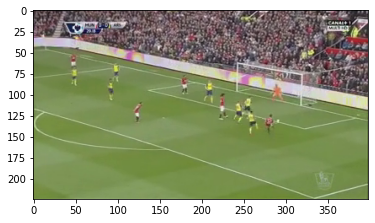

In [34]:
plt.imshow(df[0]['clip'][0,:,:,:])

In [26]:
df[0]['clip'][0,:,:,:]

tensor([[[ 90,  71,  75],
         [ 60,  41,  45],
         [ 72,  50,  53],
         ...,
         [ 71,  61,  65],
         [125, 115, 119],
         [109,  99, 103]],

        [[101,  82,  86],
         [ 84,  65,  69],
         [ 54,  32,  35],
         ...,
         [ 89,  79,  83],
         [163, 153, 157],
         [132, 122, 126]],

        [[ 78,  61,  62],
         [ 62,  45,  46],
         [ 63,  44,  46],
         ...,
         [ 77,  71,  76],
         [157, 151, 156],
         [121, 115, 120]],

        ...,

        [[102, 130,  55],
         [113, 141,  66],
         [115, 145,  67],
         ...,
         [119, 142,  80],
         [118, 141,  77],
         [ 95, 118,  54]],

        [[100, 128,  51],
         [114, 142,  65],
         [115, 145,  67],
         ...,
         [121, 144,  82],
         [119, 142,  78],
         [ 97, 120,  56]],

        [[106, 134,  57],
         [120, 148,  71],
         [122, 152,  74],
         ...,
         [127, 150,  88],
        

In [21]:
import matplotlib.pyplot as plt

In [28]:
df[0]

{'vidpath': '/hdd/sound_sn/SoccerNet-code/data/england_epl/2014-2015/2015-05-17 - 18-00 Manchester United 1 - 1 Arsenal/1.mkv',
 'clip': tensor([[[[ 90,  71,  75],
           [ 60,  41,  45],
           [ 72,  50,  53],
           ...,
           [ 71,  61,  65],
           [125, 115, 119],
           [109,  99, 103]],
 
          [[101,  82,  86],
           [ 84,  65,  69],
           [ 54,  32,  35],
           ...,
           [ 89,  79,  83],
           [163, 153, 157],
           [132, 122, 126]],
 
          [[ 78,  61,  62],
           [ 62,  45,  46],
           [ 63,  44,  46],
           ...,
           [ 77,  71,  76],
           [157, 151, 156],
           [121, 115, 120]],
 
          ...,
 
          [[102, 130,  55],
           [113, 141,  66],
           [115, 145,  67],
           ...,
           [119, 142,  80],
           [118, 141,  77],
           [ 95, 118,  54]],
 
          [[100, 128,  51],
           [114, 142,  65],
           [115, 145,  67],
           ...,

In [52]:
vf,af,_ = torchvision.io.read_video("/hdd/sound_sn/SoccerNet-code/data/england_epl/2014-2015/2015-05-17 - 18-00 Manchester United 1 - 1 Arsenal/1_conv.avi",start_pts=5,end_pts=5.5, pts_unit='sec')

In [53]:
vf.size()

torch.Size([14, 224, 398, 3])